In [8]:
# --- Make pretrained_pipeline.py importable (portable) ---
import sys
from pathlib import Path

# Adjust this if your folder name is different
project_dir = Path.cwd() / "ML-Hands-on-Activity"

# Add to Python path once
if project_dir.exists() and str(project_dir) not in sys.path:
    sys.path.insert(0, str(project_dir))

In [2]:
# ============================================================
# IMPORTS
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

from pretrained_pipeline import (
    SEED, TRAIN_DIR, TEST_DIR, device,
    set_seed,
    collect_paths,
    make_loaders,
    build_resnet18,
    train,
    evaluate
)

set_seed(SEED)

In [3]:
# ============================================================
# DATASET SUMMARY
# ============================================================

lt01_items = collect_paths(TRAIN_DIR)
train_dl, val_dl, train_items, val_items = make_loaders(
    lt01_items, seed=SEED
)

print("Dataset Summary")
print("----------------------------")
print(f"Train domain: LT01")
print(f"Train size (80% of LT01): {len(train_items)}")
print(f"Validation size (20% of LT01): {len(val_items)}")
print(f"Test domain (exchanged): LT10")
print("----------------------------\n")

Dataset Summary
----------------------------
Train domain: LT01
Train size (80% of LT01): 79
Validation size (20% of LT01): 20
Test domain (exchanged): LT10
----------------------------



In [4]:
# ============================================================
# PHASE 1 — Frozen Backbone
# ============================================================

model = build_resnet18(num_classes=10, freeze_backbone=True).to(device)

model, hist_frozen = train(
    model,
    train_dl,
    val_dl,
    epochs=10,
    lr=1e-3
)


# ============================================================
# PHASE 2 — Fine-Tuning layer4 + fc
# ============================================================

for name, p in model.named_parameters():
    if name.startswith("layer4") or name.startswith("fc"):
        p.requires_grad = True

model, hist_ft = train(
    model,
    train_dl,
    val_dl,
    epochs=5,
    lr=1e-4
)


# ============================================================
# FINAL EVALUATION ON LT10 (TRUE TEST)
# ============================================================

acc, report, cm = evaluate(model, TEST_DIR)

print(f"TEST Accuracy (LT10 exchanged): {acc:.4f}\n")
print("Classification Report (Test = LT10):")
print(report)

print("Confusion Matrix (Test = LT10):")
print(cm)

TEST Accuracy (LT10 exchanged): 0.4800

Classification Report (Test = LT10):
              precision    recall  f1-score   support

           0     0.4444    0.4000    0.4211        10
           1     0.6000    0.3000    0.4000        10
           2     1.0000    0.4000    0.5714        10
           3     0.2500    0.7000    0.3684        10
           4     0.6000    0.3000    0.4000        10
           5     1.0000    0.4000    0.5714        10
           6     0.6667    0.6000    0.6316        10
           7     0.5556    0.5000    0.5263        10
           8     0.5714    0.4000    0.4706        10
           9     0.4000    0.8000    0.5333        10

    accuracy                         0.4800       100
   macro avg     0.6088    0.4800    0.4894       100
weighted avg     0.6088    0.4800    0.4894       100

Confusion Matrix (Test = LT10):
[[4 0 0 0 0 0 0 0 1 5]
 [0 3 0 4 0 0 0 3 0 0]
 [0 0 4 6 0 0 0 0 0 0]
 [0 0 0 7 0 0 1 0 2 0]
 [0 1 0 5 3 0 0 1 0 0]
 [0 0 0 4 0 4 2 0

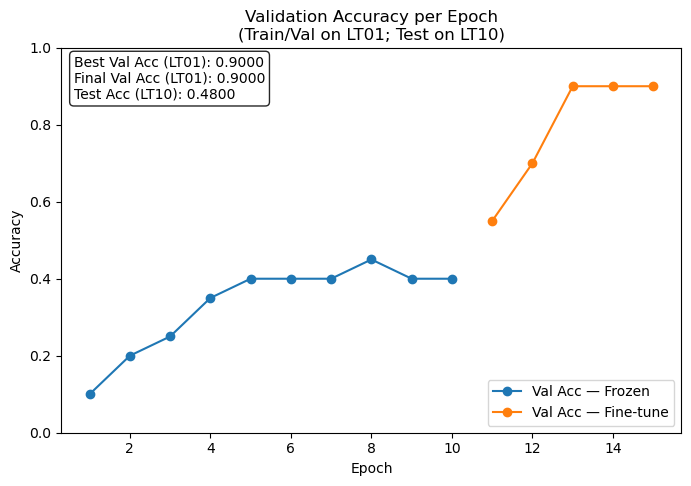

In [5]:
# ============================================================
# PLOT 1 — Validation Accuracy Curve
# ============================================================

v1 = hist_frozen["val_acc"]
v2 = hist_ft["val_acc"]

x1 = list(range(1, len(v1) + 1))
x2 = list(range(len(v1) + 1, len(v1) + len(v2) + 1))

plt.figure(figsize=(8,5))

plt.plot(x1, v1, marker="o", label="Val Acc — Frozen")
plt.plot(x2, v2, marker="o", label="Val Acc — Fine-tune")

all_val = v1 + v2
best_val = max(all_val)
final_val = all_val[-1]

metrics_text = (
    f"Best Val Acc (LT01): {best_val:.4f}\n"
    f"Final Val Acc (LT01): {final_val:.4f}\n"
    f"Test Acc (LT10): {acc:.4f}"
)

plt.gca().text(
    0.02, 0.98, metrics_text,
    transform=plt.gca().transAxes,
    va="top",
    ha="left",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.85)
)

plt.title("Validation Accuracy per Epoch\n(Train/Val on LT01; Test on LT10)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.legend()
plt.show()

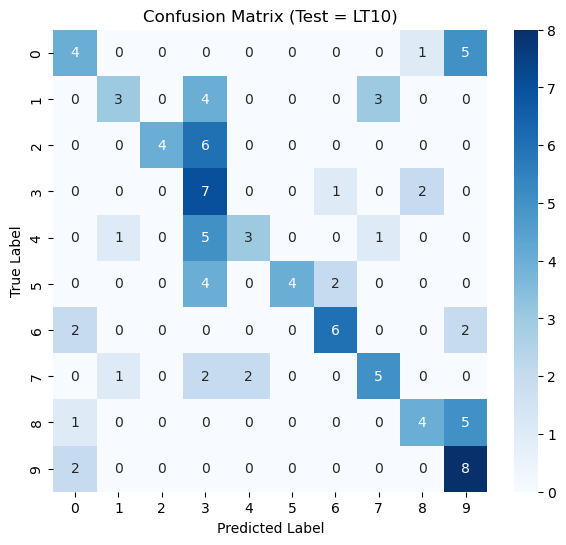

In [6]:
# ============================================================
# PLOT 2 — Confusion Matrix Heatmap
# ============================================================

plt.figure(figsize=(7,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=range(10),
    yticklabels=range(10)
)

plt.title("Confusion Matrix (Test = LT10)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [7]:
# ============================================================
# SAVE MODEL
# ============================================================

torch.save(model.state_dict(), "resnet18_digits.pth")

print("\nModel saved as resnet18_digits.pth")


Model saved as resnet18_digits.pth
